In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tqdm import tqdm

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier


In [32]:
sig_df = pd.read_pickle(Path('/Users/Ethan/Documents/UW417/Doubly Charged Higgs Search/Edited Notebooks/sig_H5pp_m300_features_SR.pkl'))
sig_df["target"] = 1

# Load background data and assign target = 0
bkg_df = pd.read_pickle(Path('/Users/Ethan/Documents/UW417/Doubly Charged Higgs Search/Edited Notebooks/bkg_ssWW_EW_features_SR.pkl'))
bkg_df["target"] = 0

In [33]:
combined_df = pd.concat([bkg_df, sig_df], ignore_index=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [34]:
for feature in combined_df.columns[:9]:
    roc_score = roc_auc_score(y_true=combined_df["target"], y_score=combined_df[feature])
    print(f"{feature}: {roc_score:.4f}")

jet1_pt_NOSYS: 0.3020
jet2_pt_NOSYS: 0.2902
mjj_NOSYS: 0.5699
dEta_jj_NOSYS: 0.7045
Et_ll_NOSYS: 0.4482
H_t_NOSYS: 0.3309
MT_dilep_NOSYS: 0.4357
pt_ll_NOSYS: 0.4299
mll_NOSYS: 0.4874


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_df.drop(columns=["weight_mc_NOSYS", "target"]),
    combined_df["target"],
    test_size=0.2,
    random_state=42,
)

In [36]:
X_train

,jet1_pt_NOSYS,jet2_pt_NOSYS,mjj_NOSYS,dEta_jj_NOSYS,Et_ll_NOSYS,H_t_NOSYS,MT_dilep_NOSYS,pt_ll_NOSYS,mll_NOSYS
4547,548817.125000,462932.031250,2.437187e+06,3.057604,356241.500000,1.226113e+06,439758.593750,178910.968750,308056.625000
30506,107534.648438,93337.046875,1.993236e+05,0.147871,96168.953125,4.414298e+05,169475.031250,67183.867188,68809.843750
37829,221637.109375,195339.531250,2.668138e+05,1.039308,417795.593750,1.198339e+06,257883.546875,363657.218750,205685.687500
22655,176756.562500,111027.914062,5.996330e+06,7.513459,194825.828125,7.268801e+05,82040.593750,186011.187500,57939.117188
30862,102611.132812,77529.296875,3.547747e+05,2.617544,86181.914062,3.695444e+05,187424.656250,75909.960938,40804.410156
...,...,...,...,...,...,...,...,...,...
54343,130501.218750,89526.414062,8.956634e+05,4.206955,99221.320312,3.913005e+05,158391.734375,43103.257812,89369.906250
38158,99002.804688,42122.886719,7.683450e+04,0.580997,83287.304688,3.757921e+05,103831.156250,45726.593750,69612.164062
860,231436.515625,175429.093750,1.118440e+06,3.366865,510813.687500,7.772122e+05,532620.625000,70496.203125,505925.812500
15795,88414.382812,55614.453125,1.030221e+06,5.367093,59670.746094,2.863916e+05,123555.023438,33125.988281,49631.312500


In [40]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV


In [41]:
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0,  # suppress training logs during search
    allow_writing_files=False  # disables unnecessary logging
)


In [42]:
param_grid = {
    'iterations': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}


In [43]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=1,  # safer on macOS, increase if running on Linux/server
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best AUC score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=0.6; total time=   1.0s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=0.6; total time=   0.9s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=0.6; total time=   0.9s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=0.8; total time=   0.9s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=0.8; total time=   0.9s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=0.8; total time=   0.9s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=1.0; total time=   1.0s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=1.0; total time=   0.9s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01, subsample=1.0; total time=   1.0s
[CV] END d

In [37]:
bdt = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)
bdt.fit(X_train, y_train)


0:	total: 7.92ms	remaining: 3.95s
100:	total: 518ms	remaining: 2.05s
200:	total: 999ms	remaining: 1.49s
300:	total: 1.49s	remaining: 984ms
400:	total: 1.97s	remaining: 486ms
499:	total: 2.45s	remaining: 0us


In [38]:
bdt_test_score = bdt.predict_proba(X_test)[:, 1]
print(f"BDT ROC AUC: {roc_auc_score(y_true=y_test, y_score=bdt_test_score):.4f}")

BDT ROC AUC: 0.8708


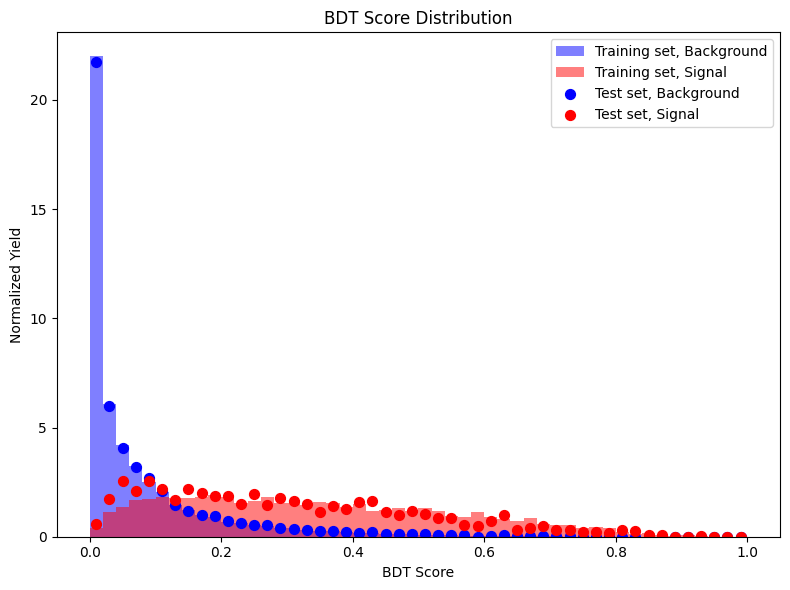

In [39]:
# plot the bdt scores for training and test dataset 

bin_edges = np.linspace(0, 1, 51)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bdt_train_score = bdt.predict_proba(X_train)[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    bdt_train_score[y_train == 0],
    bins=bin_edges,
    alpha=0.5,
    label="Training set, Background",
    color="blue",
    density=True,
)

ax.hist(
    bdt_train_score[y_train == 1],
    bins=bin_edges,
    alpha=0.5,
    label="Training set, Signal",
    color="red",
    density=True,
)

bdt_test_score_hist_yield_bkg, _ = np.histogram(
    bdt_test_score[y_test == 0],
    bins=bin_edges,
    density=True,
)
bdt_test_score_hist_yield_sig, _ = np.histogram(
    bdt_test_score[y_test == 1],
    bins=bin_edges,
    density=True,
)

ax.scatter(
    bin_centers,
    bdt_test_score_hist_yield_bkg,
    label="Test set, Background",
    color="blue",
    marker="o",
    s=50,
)
ax.scatter(
    bin_centers,
    bdt_test_score_hist_yield_sig,
    label="Test set, Signal",
    color="red",
    marker="o",
    s=50,
)

ax.set_xlabel("BDT Score")
ax.set_ylabel("Normalized Yield")
ax.set_title("BDT Score Distribution")
ax.legend()

plt.tight_layout()